In [ ]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

##ORB (Oriented FAST and Rotated BRIEF)

Количество ключевых точек: 409
Размер дескрипторов: (409, 32)


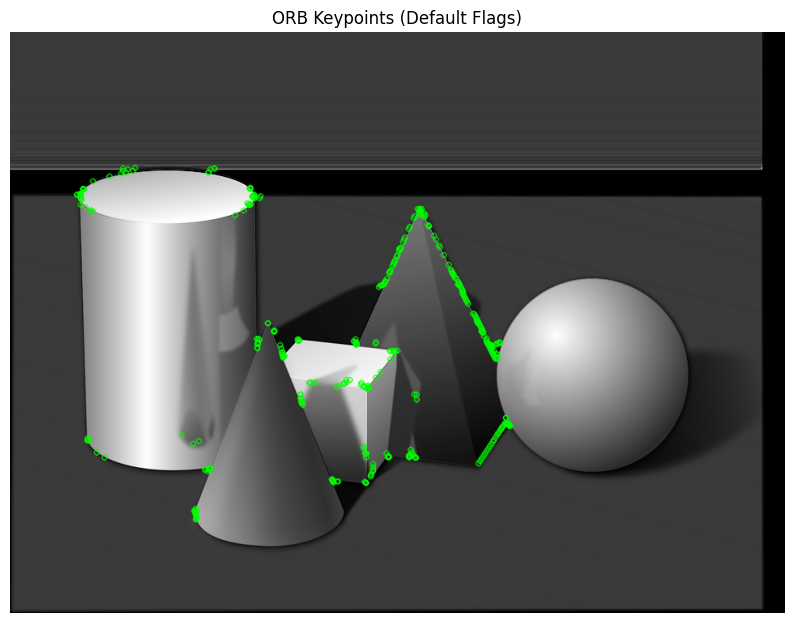

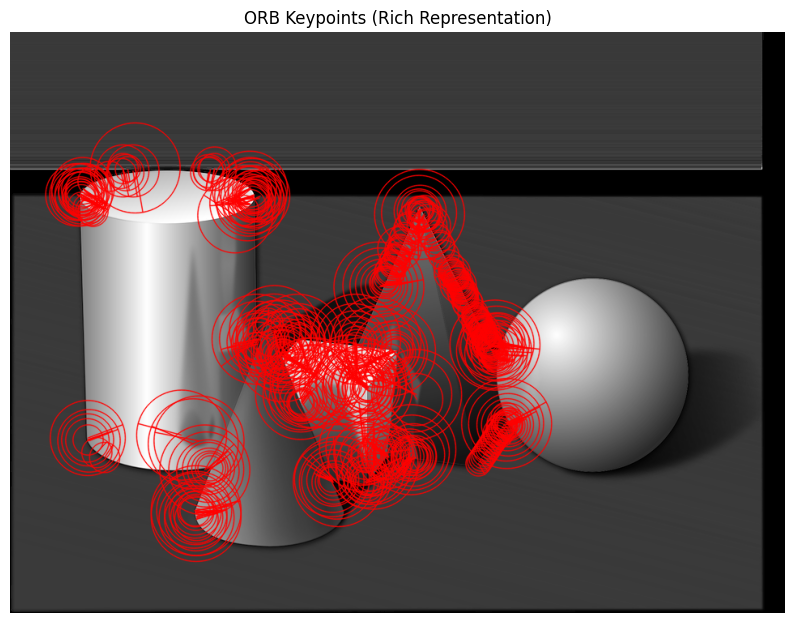

In [ ]:
# Загрузка изображения в градациях серого
img = cv.imread('figs.png', cv.IMREAD_GRAYSCALE)

# Инициализация детектора ORB
orb = cv.ORB_create(nfeatures=500, scoreType=cv.ORB_HARRIS_SCORE, WTA_K=2)

# Обнаружение ключевых точек
kp = orb.detect(img, None)

# Вычисление дескрипторов ORB
kp, des = orb.compute(img, kp)

# Вывод информации о количестве ключевых точек и размере дескрипторов
print(f"Количество ключевых точек: {len(kp)}")
print(f"Размер дескрипторов: {des.shape}")

# Отображение ключевых точек без размера и ориентации
img_with_keypoints = cv.drawKeypoints(img, kp, None, color=(0, 255, 0), flags=cv.DrawMatchesFlags_DEFAULT)

# Визуализация ключевых точек через matplotlib
plt.figure(figsize=(10, 10))
plt.title("ORB Keypoints (Default Flags)")
plt.imshow(img_with_keypoints, cmap='gray')
plt.axis('off')
plt.show()

# Отображение ключевых точек с ориентацией и размерами
img_with_rich_keypoints = cv.drawKeypoints(
    img, kp, None, color=(255, 0, 0), flags=cv.DrawMatchesFlags_DRAW_RICH_KEYPOINTS
)

# Визуализация ключевых точек с ориентацией и размерами
plt.figure(figsize=(10, 10))
plt.title("ORB Keypoints (Rich Representation)")
plt.imshow(img_with_rich_keypoints, cmap='gray')
plt.axis('off')
plt.show()


##Feature Matching

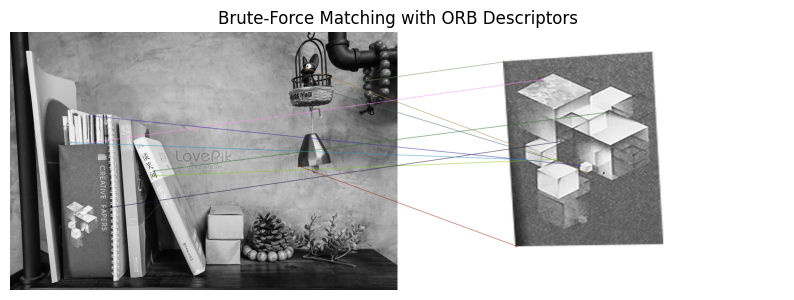

In [ ]:
# Загрузка изображений
img1 = cv.imread('rand.jpg', cv.IMREAD_GRAYSCALE)          # Изображение-запрос
img2 = cv.imread('rand_pic.jpg', cv.IMREAD_GRAYSCALE) # Обучающее изображение

# Инициализация ORB детектора
orb = cv.ORB_create()

# Нахождение ключевых точек и дескрипторов с помощью ORB
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

# Создание BFMatcher объекта
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)

# Сопоставление дескрипторов
matches = bf.match(des1, des2)

# Сортировка по расстоянию (чем меньше расстояние, тем лучше совпадение)
matches = sorted(matches, key=lambda x: x.distance)

# Рисование первых 10 совпадений
img3 = cv.drawMatches(img1, kp1, img2, kp2, matches[:10], None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Отображение результатов
plt.figure(figsize=(10, 10))
plt.title("Brute-Force Matching with ORB Descriptors")
plt.imshow(img3)
plt.axis('off')
plt.show()


### Brute-Force Matching с SIFT дескрипторами и Ratio Test

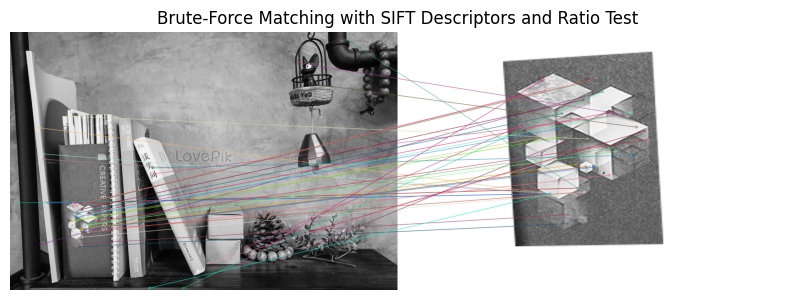

In [ ]:
# Загрузка изображений
img1 = cv.imread('rand.jpg', cv.IMREAD_GRAYSCALE)          # Изображение-запрос
img2 = cv.imread('rand_pic.jpg', cv.IMREAD_GRAYSCALE) # Обучающее изображение

# Инициализация SIFT детектора
sift = cv.SIFT_create()

# Нахождение ключевых точек и дескрипторов с помощью SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# Создание BFMatcher объекта с параметрами по умолчанию
bf = cv.BFMatcher()

# Сопоставление дескрипторов с использованием knnMatch
matches = bf.knnMatch(des1, des2, k=2)

# Применение теста соотношения
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append([m])

# Рисование совпадений
img3 = cv.drawMatchesKnn(img1, kp1, img2, kp2, good_matches, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Отображение результатов
plt.figure(figsize=(10, 10))
plt.title("Brute-Force Matching with SIFT Descriptors and Ratio Test")
plt.imshow(img3)
plt.axis('off')
plt.show()


### FLANN Matching

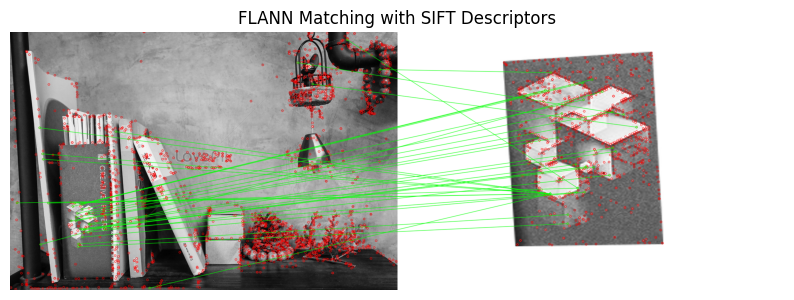

In [ ]:
# Загрузка изображений
img1 = cv.imread('rand.jpg', cv.IMREAD_GRAYSCALE)          # Изображение-запрос
img2 = cv.imread('rand_pic.jpg', cv.IMREAD_GRAYSCALE) # Обучающее изображение

# Инициализация SIFT детектора
sift = cv.SIFT_create()

# Нахождение ключевых точек и дескрипторов с помощью SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# Параметры FLANN
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)  # Проверки во время поиска

# Создание FLANN объекта
flann = cv.FlannBasedMatcher(index_params, search_params)

# Сопоставление дескрипторов с использованием knnMatch
matches = flann.knnMatch(des1, des2, k=2)

# Создание маски для отображения только "хороших" совпадений
matchesMask = [[0, 0] for _ in range(len(matches))]
for i, (m, n) in enumerate(matches):
    if m.distance < 0.7 * n.distance:
        matchesMask[i] = [1, 0]

# Параметры рисования
draw_params = dict(matchColor=(0, 255, 0),  # Зеленый для хороших совпадений
                   singlePointColor=(255, 0, 0),  # Красный для одиночных точек
                   matchesMask=matchesMask,  # Маска совпадений
                   flags=cv.DrawMatchesFlags_DEFAULT)

# Рисование совпадений
img3 = cv.drawMatchesKnn(img1, kp1, img2, kp2, matches, None, **draw_params)

# Отображение результатов
plt.figure(figsize=(10, 10))
plt.title("FLANN Matching with SIFT Descriptors")
plt.imshow(img3)
plt.axis('off')
plt.show()

##Feature Matching + Homography to find Objects

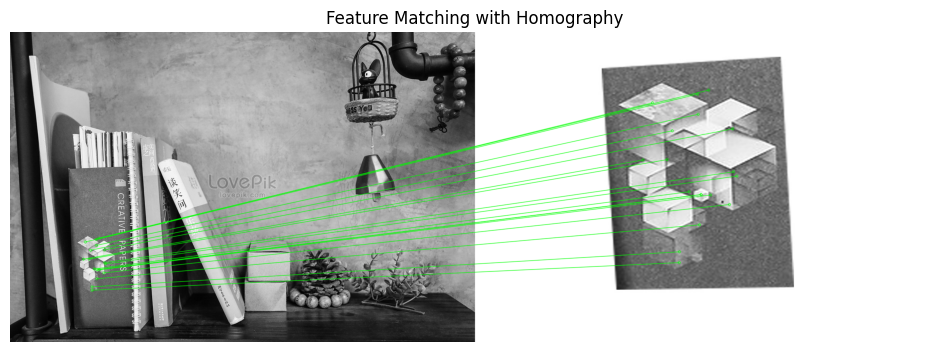

In [ ]:
# Минимальное количество совпадений для успешного нахождения объекта
MIN_MATCH_COUNT = 10

# Загрузка изображений
img1 = cv.imread('rand.jpg', cv.IMREAD_GRAYSCALE)
img2 = cv.imread('rand_pic.jpg', cv.IMREAD_GRAYSCALE)

# Инициализация SIFT детектора
sift = cv.SIFT_create()

# Нахождение ключевых точек и дескрипторов с помощью SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# Параметры FLANN
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)  # Число проверок

# Создание FLANN объекта
flann = cv.FlannBasedMatcher(index_params, search_params)

# Сопоставление дескрипторов с использованием knnMatch
matches = flann.knnMatch(des1, des2, k=2)

# Применение теста соотношения для фильтрации совпадений
good = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good.append(m)

if len(good) > MIN_MATCH_COUNT:
    # Извлечение координат совпавших ключевых точек
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

    # Нахождение гомографии
    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)
    matchesMask = mask.ravel().tolist()

    # Размеры исходного изображения
    h, w = img1.shape
    pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
    dst = cv.perspectiveTransform(pts, M)

    # Отображение найденного объекта на обучающем изображении
    img2 = cv.polylines(img2, [np.int32(dst)], True, 255, 3, cv.LINE_AA)
else:
    print(f"Not enough matches are found - {len(good)}/{MIN_MATCH_COUNT}")
    matchesMask = None

# Параметры для рисования совпадений
draw_params = dict(matchColor=(0, 255, 0),  # Рисование совпадений зеленым цветом
                   singlePointColor=None,
                   matchesMask=matchesMask,  # Рисовать только inliers
                   flags=2)

# Рисование совпадений
img3 = cv.drawMatches(img1, kp1, img2, kp2, good, None, **draw_params)

# Отображение результата
plt.figure(figsize=(12, 8))
plt.imshow(img3, 'gray')
plt.title('Feature Matching with Homography')
plt.axis('off')
plt.show()